This Jupyter notebook aims to show:

- how aircraft wake vortices are modelled,
- how to analyse and fit vortex profiles obtained from LiDAR measurement during flights tests,
- how to calculate vortex characteristics such as their size (core radius) and strength (circulation)

### Import the required libraries

In [1]:
import random
from math import pi, sqrt

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from scipy.optimize import curve_fit
import scipy.integrate as integrate

from sklearn.metrics import mean_squared_error

# Vortex models

Below some 2D vortex models are presented

## Lamb-Oseen model

https://en.wikipedia.org/wiki/Lamb%E2%80%93Oseen_vortex

Here, we are interested in the form of the Lamb-Oseen model for wake vortices:

$V(r) = \frac{\Gamma} {2 {\pi}} (1 - exp(-1.256\frac{r^2}{r_c^2}))$

where:

- ${\Gamma}$ is the circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core radius, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [2]:
def lamb_oseen(r, gamma, rc):
    """
    r: radial distance in m
    gamma: circulation in m^2/s
    rc: core_radius in m
    ---
    returns the tangential velocity as a function of radial distance
    """
    # Small manipulation to avoid the case r = 0
    r_new = (r == 0).astype(int) / 1000 + r
    return gamma / (2 * pi * r_new) * (1 - np.exp( - 1.256 * r ** 2 / rc ** 2))

## Rankine model

https://en.wikipedia.org/wiki/Rankine_vortex

The drawback the rankine model is its non-linearity.

$V(r) = \frac{\Gamma r}{2 {\pi} r_c^2}$ for $r \le r_c$

$V(r) = \frac{\Gamma}{2 {\pi} r}$ for $r > r_c$

where:

- ${\Gamma}$ is the circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core size, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [3]:
def rankine(r, gamma, rc):
    """
    r: radial distance in m
    gamma: circulation in m^2/s
    rc: core_radius in m
    ---
    returns the tangential velocity as a function of radial distance
    """
    # Velocity inside the vortex core
    internal_V = (abs(r) <= rc).astype(int) * gamma * r /( 2 * pi * rc**2)
    
    # Small manipulation to avoid the case r = 0 
    r_new = (r == 0).astype(int) / 1000 + r

    # Velocity outside the vortex core
    external_V = (abs(r) > rc).astype(int) * gamma / (2 * pi * r_new)
    
    return internal_V + external_V

## Burnham-Hallock model

The Burnham-Hallock model is widely used to model aircraft wake vortices.

$V(r)=\frac{\Gamma}{2{\pi}r}\frac{r^2}{r^2+r_c^2}$

where:

- ${\Gamma}$ is the circulation
- ${r}$ is the distance from the vortex center or radial distance
- ${r_c}$ is the mean vortex core radius, i.e. the half of distance between velocity peaks
- ${V(r)}$ is the tangential velocity a r

In [4]:
def burnham_hallock(r, gamma, rc):
    """
    r: radial distance in m
    gamma: circulation in m^2/s
    rc: core_radius in m
    ---
    returns the tangential velocity as a function of radial distance
    """
    return gamma / (2 * pi) * r / (r ** 2 + rc ** 2)

## Comparison of the models

Let's define a vortex with **300** m^2/s circulation and a core radius of **4** m between -20m and 20m and plot the vortex profile

In [5]:
r_max = 20
r_min = -r_max
r_step = 0.5

circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)

# Lamb Oseen Profile
velocity_lo = lamb_oseen(radial_distance, circulation, core_radius)

# Rankine Profile
velocity_ra = rankine(radial_distance, circulation, core_radius)

# Burnham-Hallock Profile
velocity_bh = burnham_hallock(radial_distance, circulation, core_radius)

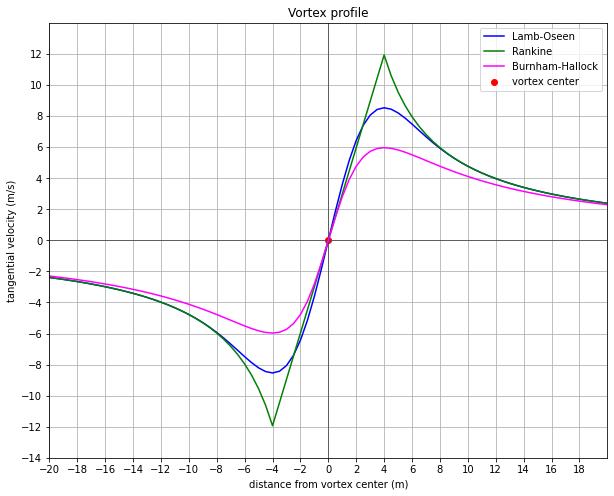

In [6]:
%matplotlib inline

y_max = int(max(np.max(velocity_lo), np.max(velocity_ra), np.max(velocity_bh)) / 2) * 2 + 4
x_max = r_max

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 2)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.plot(radial_distance, velocity_lo, color='blue', label='Lamb-Oseen')
ax.plot(radial_distance, velocity_ra, color='green', label='Rankine')
ax.plot(radial_distance, velocity_bh, color='magenta', label='Burnham-Hallock')

ax.set(xlabel='distance from vortex center (m)', ylabel='tangential velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/comparison_of_vortex_profiles.png")
plt.legend()
plt.show()

# Analysis of LiDAR measurements - single vortex

## Re-construction of a LiDAR envelope

The analysis of aircraft wake vortices is made using data provided by post-processed LiDAR data from flight test measurements. These data consist of envelopes of the measured tangential velocity as a function of the radial distance (distance from the position of the vortex center).

Because I don't have any data of this kind (for obvious confidentiality reasons), these data need to be re-constructed. 

To make the data more realistic, following additional parameters must be added to the model equations:

- random background noise
- random radial shift $\Delta r_c$
- random tangential velocity shift $\Delta V$
- random error around the calculted profile $\delta \epsilon_V$

The measurements are discrete, that means, that we obtained points on the velocity profile at a regular interval, the so-called LiDAR resolution.

In [7]:
def add_noise_to_envelope(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Add noise to the envelope.
    Noise is assumed to be 2 m/s
    The envelope is crossing the axis y = 0 (tangential velocity = 0) only in the core
    """
    noise = np.random.normal(1, 0.25, velocity.shape) * np.sign(velocity)
    return np.maximum(np.abs(velocity), noise) * np.sign(velocity)

In [8]:
def add_shift():
    """
    Returns two random numbers for radial and velocity shift
    """
    return random.gauss(0, 0.25), random.gauss(0, 0.25)

In [9]:
def add_random_error(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Add random error to the velocity profile
    An error of +/- 0.5 m/s is added to the profile
    """
    return velocity + np.random.normal(0, 0.25, velocity.shape)

In [10]:
def generate_lidar_envelope(r, Gamma, rc, model=burnham_hallock):
    """
    r: radial distance in m
    gamma: circulation in m^2/s
    rc: core_radius in m
    model: vortex model among burnham-hallock, lamb_oseen and rankine
    ---
    Return the full vortex profile including noise, shifts and error
    """
    Delta_r, Delta_V = add_shift()
    
    # radial shift
    r -= Delta_r
    
    # Velocity profile
    velocity_profile = model(r, Gamma, rc)
    
    # add the noise
    velocity_profile = add_noise_to_envelope(velocity_profile)
    
    # add the random_error
    velocity_profile = add_random_error(velocity_profile)
    
    # Add tangential velocity shift
    return velocity_profile + Delta_V, Delta_r, Delta_V

In [11]:
def set_lidar_resolution():
    """
    Return the lidar resolution, i.e. the average radial distance between two data points
    """
    return random.uniform(1, 3)

Let's define a vortex with **300** m^2/s circulation and a core radius of **3** m between -100m and 100m and plot the vortex profile with the LiDAR envelope.

For this exercise, we use a Burnham-Hallock profile.

In [12]:
r_max = 100
r_min = -r_max
r_step = set_lidar_resolution()

circulation = 300
core_radius = 4

radial_distance = np.arange(r_min, r_max+r_step, r_step)
radial_distance_model = np.arange(r_min, r_max+1, 0.5)

velocity_lidar, Delta_r, Delta_V = generate_lidar_envelope(radial_distance, circulation, core_radius)
velocity_model = burnham_hallock(radial_distance_model, circulation, core_radius)

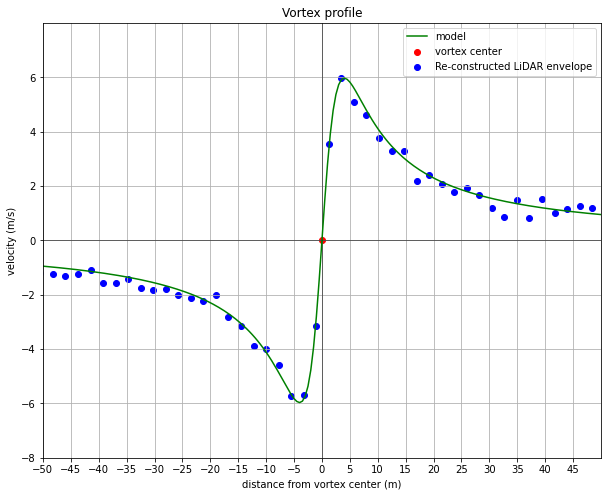

In [13]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='Re-constructed LiDAR envelope')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope.png")
plt.legend()
plt.show()

## Fitting the LiDAR profile

The current step consists in doing the other way: from the reconstructed LiDAR profile, the data will be fitted to estimate the original vortex characteristics

The adapted Burnham-Hallock model fitting the reconstructed data or the vortex profile data obtained from the LiDAR processing looks like:

$V(r)=\frac{\Gamma}{2{\pi}(r-\Delta r_c)}\frac{(r-\Delta r_c)^2}{(r-\Delta r_c)^2+r_c^2} + \Delta V$ 

Therefore, there are 4 unknown for this equation:

- $\Gamma$, the circulation of the vortex
- $r_c$, the core radius of the vortex
- $\Delta r_c$, the radial shift
- $\Delta V$, the velocity shift

### Modified Burnham-Hallock model

In [14]:
def modified_burnham_hallock(r, gamma, rc, delta_r, delta_V):
    """
    gamma: circulation in m^2/s
    rc: core_radius in m
    r: radial distance in m
    delta_r: radial shift in m
    delta_V: tangential velocity shift in m/s
    ---
    Returns the tangential velocity as a function of the radial distance
    """
    return gamma / (2 * pi) * (r - delta_r) / ( (r - delta_r )** 2 + rc**2) + delta_V

### Position of Velocity peaks
The positions of the velocity peaks are read from the LiDAR profile.

In [15]:
def get_min_max_index(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns the indices of the peak of velocities
    """
    return np.argmin(velocity), np.argmax(velocity)

In [16]:
def get_min_max_radii(radial_distance, velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the distance from the vortex center for the peak of velocities
    """
    # Indices of both velocity peaks
    idx_min, idx_max = get_min_max_index(velocity)
    
    return radial_distance[idx_min], radial_distance[idx_max]

In [17]:
def get_min_max_velocity(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the values of the peak velocities
    """
    return np.min(velocity), np.max(velocity)

### Mean tangential velocities
The mean tangential velocity is the mean of the absolute velocity.

Positive and negative mean tangential velocities outside the vortex core are calculated separately.

In [18]:
def get_abs_mean_velocity(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns the average of absolute tangential velocities of the vortex profile
    """
    return np.mean(np.abs(velocity))

In [19]:
def get_neg_pos_mean_velocities(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    Return the average of tangential velocities of the negative and positive vortex sides separately
    """
    # Indices of both velocity peaks
    idx_min, idx_max = get_min_max_index(velocity)
    
    return np.mean(velocity[:idx_min+1]), np.mean(velocity[idx_max:])

### Removal of outliers / noise
#### Noise - Cuf-off


Points far from the core are not to be separated from the noise. A cut-off is introduced under the following assumptions:

- Only a relatively small number of points is measured around the core,
- Their tangential velocities are bigger than the noise,
- In that case, the mean tangential velocity is slighty bigger than the envelope of the noise,
- Every point under the mean velocity may therefore be considered as noise and will be removed,
- To avoid an early cut-off due to a single outlier, there must be at least 3 points in a row under the mean velocity to locate the cut-off position.
- Points at the limit of the window are considered to be noise.

Points inside the vortex core with tangential velocity smaller than the mean velocity are also removed as noise.

This method is used for positive and negative velocities separately.

In [20]:
def count_points_outside_noise(velocity):
    """
    velocity: velocity profile (envelope) as a numpy array
    ---
    For every point on the profile, counts the number of neighbour points, i.e. the previous and following 
    points as well as the point itself, with tangential velocity above noise.
    A non-zero value means that at least one of these points has a tangential velocity above noise.
    A zero value means that all these three points belongs to the noise, i.e. their tangential 
    velocity is below the noise.
    Exception is done by points inside vortex core, where only the point itself without its neighbours is 
    taken into account.
    
    Returns a numpy array with the number of direct neighbour points with tangential velocity above noise
    """
    # negative and positive mean tangential velocities for cut-off, i.e. noise envelope
    v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity)
    
    # Indices of both velocity peaks
    idx_min, idx_max = get_min_max_index(velocity)
    
    # negative envelope : gives 0 when the previous and following points have a smaller 
    #                     absolute tangential velocity than the noise
    negative_points = np.append(np.zeros(1), [(velocity[i-1] <= v_neg_mean).astype(int) +
                                              (velocity[i] <= v_neg_mean).astype(int) + 
                                              (velocity[i+1] <= v_neg_mean).astype(int) 
                                              for i in range(1, len(velocity)-1)])
    negative_points = np.append(negative_points, np.zeros(1))
    
    # positive envelope : gives 0 when the previous and following points have a smaller 
    #                     tangential velocity than the noise
    positive_points = np.append(np.zeros(1), [(velocity[i-1] >= v_pos_mean).astype(int) +
                                              (velocity[i] >= v_pos_mean).astype(int) + 
                                              (velocity[i+1] >= v_pos_mean).astype(int) 
                                              for i in range(1, len(velocity)-1)])
    positive_points = np.append(positive_points, np.zeros(1))
    
    # points in the vortex core : gives 0 when the tangential velocity is smaller than the noise
    core_points = np.concatenate((np.ones(idx_min), 
                                  np.abs(velocity[idx_min:idx_max]) >= 
                                         0.5 * (v_pos_mean - v_neg_mean), 
                                                np.ones(velocity.shape - idx_max)))
    
    return (negative_points + positive_points) * core_points

In [21]:
def remove_values_from_profile(vector, points, velocity):
    """
    vector: numpy array containing the velocity profile or radial distance
    points: numpy array containing for every point, the number of direct neighbours with tangential velocity
            above noise.
    velocity: velocity profile (envelope) as a numpy array
    ---
    Returns a reduced vector containing only selected data points used for the fitting
    """
    # Indices of min. ann max. tangential velocity
    idx_min, idx_max = get_min_max_index(velocity)
    
    # Index of points inside the core to be removed of the profile
    idx_core = np.where(points[idx_min:idx_max] == 0)
    
    # Index of the closest point to the negative velocity peak where the number of neighbour points
    # with tangential velocity below noise is 0
    idx_start = np.where(points[:idx_min] == 0)[0][-1]

    # Index of the closest point to the positive velocity peak where the number of neighbour points
    # with tangential velocity below noise is 0
    idx_end = np.where(points[idx_max:] == 0)[0][0] + idx_max

    # No points inside the core are removed
    if idx_core[0].size == 0:
        return vector[idx_start:idx_end+1]
    
    # Indices of the core points to be removed
    idx_core_min = idx_core[0][0] + idx_min
    idx_core_max = idx_core[0][-1] + idx_min
    
    return np.concatenate((vector[idx_start:idx_core_min], vector[idx_core_max+1:idx_end+1]))

In [22]:
counted_points = count_points_outside_noise(velocity_lidar)
distance_for_fitting = remove_values_from_profile(radial_distance, counted_points, velocity_lidar)
velocity_for_fitting = remove_values_from_profile(velocity_lidar, counted_points, velocity_lidar)

In [23]:
v_neg_mean, v_pos_mean = get_neg_pos_mean_velocities(velocity_lidar)

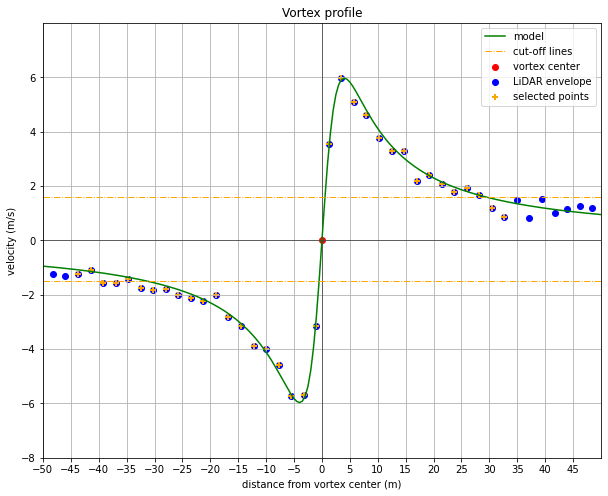

In [24]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_selected_points.png")
plt.legend()
plt.show()

### Fit the LiDAR profile with the built-in function curve_fit

In [25]:
fitted_values, _ = curve_fit(modified_burnham_hallock, 
                             distance_for_fitting, 
                             velocity_for_fitting, 
                             p0 = [100,1,0,0])

### Comparisons

#### Comparison of fitted characteristics with initial characteristics

In [26]:
original_values = [circulation, core_radius, Delta_r, Delta_V]

comparison_table = pd.DataFrame({'Original': original_values, 'Fit': fitted_values, 
                                 'Error': original_values - fitted_values,
                                 'Rel. error (%)': 100 * (original_values - fitted_values) / original_values},
                                index=['Circulation [m^2/s]', 'Core radius [m]', 
                                       'Delta_r [m]', 'Delta_V [m/s]'])

comparison_table.round(2)

,Original,Fit,Error,Rel. error (%)
Circulation [m^2/s],300.00,291.12,8.88,2.96
Core radius [m],4.00,3.89,0.11,2.67
Delta_r [m],-0.10,-0.03,-0.07,69.32
Delta_V [m/s],-0.11,-0.12,0.01,-9.43


Based on these original characteristics, core radius and circulation are well estimated.

In [27]:
def root_mean_square_error(velocity_for_fitting, velocity_from_fitting):
    """
    velocity_for_fitting: numpy array containing the velocity profile before fitting
    velocity_from_fitting: numpy array containing the fitted velocity profile
    ---
    Returns the root-mean-square error of the fit
    """
    return sqrt(mean_squared_error(velocity_for_fitting, velocity_from_fitting))

In [28]:
velocity_from_fitting = modified_burnham_hallock(distance_for_fitting, 
                                                 circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

RMSE = root_mean_square_error(velocity_for_fitting, velocity_from_fitting)

print(f"The root-mean-square error is {RMSE:0.3f} m/s")

The root-mean-square error is 0.230 m/s


#### Comparison of original, re-constructed and fitted profiles all together

In [29]:
velocity_from_fitting = modified_burnham_hallock(radial_distance_model, 
                                                 circulation, 
                                                 core_radius, 
                                                 Delta_r, Delta_V)

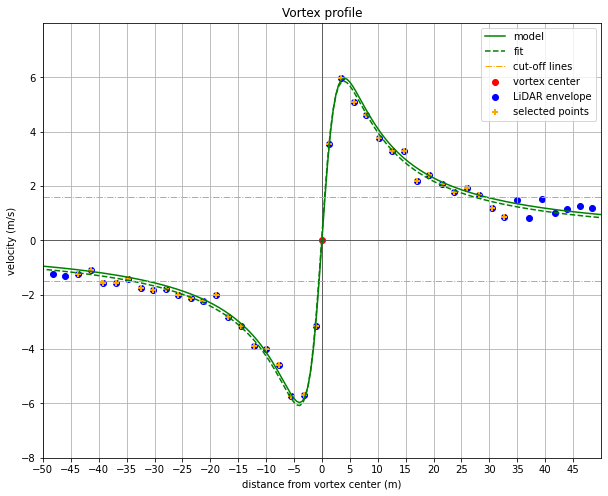

In [30]:
%matplotlib inline

y_max = int(max(velocity_lidar) / 2) * 2 + 4
x_max = 50

fig, ax = plt.subplots(figsize=(10, 8))

xticks = np.arange(-x_max, x_max, 5)
yticks = np.arange(-y_max, y_max, 2)

plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)
plt.scatter([0],[0], color='red', label='vortex center')

ax.scatter(radial_distance, velocity_lidar, color='blue', label='LiDAR envelope')
ax.scatter(distance_for_fitting, velocity_for_fitting, marker='+', color='orange', \
           lw=2, label='selected points')
ax.plot(radial_distance_model, velocity_model, color='green', label='model')
ax.plot(radial_distance_model, velocity_from_fitting, color='green', ls='--', label='fit')

plt.axhline(v_neg_mean, color='orange', lw=1, ls='-.', label='cut-off lines')
plt.axhline(v_pos_mean, color='orange', lw=1, ls='-.')

ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Vortex profile')
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.xlim(-x_max, x_max)
plt.ylim(-y_max, y_max)

plt.grid(b=True)

fig.savefig("./images/single_lidar_envelope_with_fit.png")
plt.legend()
plt.show()

## Circulation between 5 and 15m

The circulation of a single vortex is a function of radial distance from the vortex center r and the tangential velocity V(r)

$\Gamma(r) = 2 \pi r V(r)$

In cases of wake vortex analysis the standardized circulation is the circulation calculated between 5 and 15m from the vortex center, i.e. the averaged integral within this range.

### Integral form

The integral form is used to calculated the circulation of the original and fitted profiles

In [31]:
def circulation_full_integral(model, a, b, gamma, rc, delta_r=0, delta_V=0):
    """
    model: vortex model among burnham-hallock, lamb_oseen and rankine
    a: lower limit of integration
    b: upper limit of integration
    gamma: circulation in m^2/s
    rc: core_radius in m
    delta_r: radial shift in m
    delta_V: tangential velocity shift in m/s
    ---
    Returns the averaged integral of the circulation from a to b
    """
    return integrate.quad(lambda r: 2 * pi * r * model(r, gamma, rc, delta_r, delta_V), a, b)[0] / (b - a)

#### Circulation 5-15m of the original data

In [32]:
gamma5to15_full = circulation_full_integral(modified_burnham_hallock, 5, 15, circulation, core_radius)

In [33]:
print(f"The circulation 5-15m for this vortex is {gamma5to15_full:0.1f} m^2")
print(f"This represents {100*gamma5to15_full/circulation:0.1f} % of the circulation")

The circulation 5-15m for this vortex is 250.3 m^2
This represents 83.4 % of the circulation


#### Circulation 5-15m of the fitted data

In [34]:
gamma5to15_fitted = circulation_full_integral(modified_burnham_hallock,
                                              5, 15, 
                                              fitted_values[0], 
                                              fitted_values[1],
                                              fitted_values[2],
                                              fitted_values[3])

In [35]:
print(f"The circulation 5-15m for this vortex is {gamma5to15_fitted:0.1f} m^2")
print(f"This represents {100*gamma5to15_fitted/circulation:0.1f} % of the circulation")

The circulation 5-15m for this vortex is 236.7 m^2
This represents 78.9 % of the circulation


### Discrete form

The discrete form is used to calculate the circulation of the LiDAR profile.

In [36]:
def circulation_selection_of_points(radial_distance, velocity, a=5, b=15):
    """
    radial distance: distance from the vortex center as numpy array
    velocity: velocity profile (envelope) as a numpy array
    a: lower limit of integration
    b: upper limit of integration
    ---
    Returns the selected points between a and b    """
    preselected_r = radial_distance[np.abs(radial_distance) <= b]
    preselected_V = velocity[np.abs(radial_distance) <= b]
    
    selected_r = preselected_r[np.abs(preselected_r) >= a]
    selected_V = preselected_V[np.abs(preselected_r) >= a]

    return selected_r, selected_V

In [37]:
def circulation_discrete_integral(radial_distance, velocity, a=5, b=15):
    """
    radial distance: distance from the vortex center as numpy array
    velocity: velocity profile (envelope) as a numpy array
    a: lower limit of integration
    b: upper limit of integration
    ---
    Returns the averaged circulation between a and b
    """
    selected_r, selected_V = circulation_selection_of_points(radial_distance, velocity, a, b)
    return np.sum(2 * pi * selected_r * selected_V) / len(selected_r)

In [38]:
gamma5to15_discrete = circulation_discrete_integral(radial_distance, velocity_lidar, 5, 15)

In [39]:
print(f"The circulation 5-15m for this vortex is {gamma5to15_discrete:0.1f} m^2")
print(f"This represents {100*gamma5to15_discrete/circulation:0.1f} % of the circulation")

The circulation 5-15m for this vortex is 247.6 m^2
This represents 82.5 % of the circulation


### Comparison of circulations

In [40]:
circulations = np.array([gamma5to15_full, gamma5to15_discrete, gamma5to15_fitted])

comparison_table = pd.DataFrame({'5-15m Circulation [m^2/s]': circulations, 
                                 'Error': circulations - circulations[0], 
                                 'Rel. error (%)': 100 * (circulations - circulations[0]) / circulations[0]},
                                index=['Original', 'LiDAR', 'Fitted'])

comparison_table.round(2)

,5-15m Circulation [m^2/s],Error,Rel. error (%)
Original,250.30,0.00,0.00
LiDAR,247.61,-2.70,-1.08
Fitted,236.73,-13.58,-5.42


# Analysis of LiDAR measurements - batch analysis

In this part, several vortices are randomly generated and then analysed by the fitting method and circulation calculation. They are finally compared with the original data to assess the methodology.

## Generation of random vortex profiles

Set the parameter vortex_generation_on to True in order to generate random vortex profiles.
Set the parameter vortex_generation_on to False in order to read the vortex profiles from a existing files.

In [41]:
vortex_generation_on = True

vortex_filename = './data/vortices.csv'
profile_filename = './data/profiles_'

The number of vortices is set to

In [42]:
n_vortices = 1000

The vortex circulation is assumed to be uniformly distributed in the range between 100 and 600 m^2/s.

The core size or vortex radius is assumed to be uniformly distributed in the range between 1 and 5 m. 

All vortex profiles are generated between -100 and 100m with random resolution.

The generated vortex profiles are gathered in a single list

In [43]:
def generate_n_vortex_profiles(n=1, circ_min=100, circ_max=600, size_min=1, size_max=5, r_max=100):
    """
    n: Number of vortices to be generated
    circ_min, circ_max = Range of the vortex circulation in m²/s
    size_min, size_max = Range of the vortex size in m
    r_max = maximum radial distance
    ---
    Returns
    n vortex profiles within the given characteristics
    """
    # Circulation
    circulations = np.random.randint(circ_min, circ_max, n)
    
    # core size / vortex radius
    sizes = np.random.randint(size_min*100.0, size_max*100.0, n) / 100.0
    
    # radial range
    r_min = -r_max
    
    # LiDAR resolution
    resolutions = np.array([set_lidar_resolution() for _ in range(n)])
    
    # Generations of vortex profiles
    radial_distances = [np.arange(r_min, r_max+resolutions[n], resolutions[n]) for n in range(n)]

    generated_velocities = [generate_lidar_envelope(np.arange(r_min, r_max+resolutions[n], resolutions[n]), 
                             circulations[n], sizes[n]) for n in range(n)]
    
    velocities = [generated_velocities[n][0] for n in range(n)]
    delta_r = [generated_velocities[n][1] for n in range(n)]
    delta_v = [generated_velocities[n][2] for n in range(n)]
    
    # 5-15m Circulation
    gamma5to15 = [circulation_full_integral(modified_burnham_hallock, 5, 15, circulations[n], 
                                                 sizes[n], 0, 0) for n in range(n)]
    
    return (circulations, sizes, gamma5to15, delta_r, delta_v), (radial_distances, velocities)

In [44]:
if vortex_generation_on:
    vortices, profiles = generate_n_vortex_profiles(n_vortices)

#### Write the data of generated profiles in a pandas dataframe and save it in the corresponding file

In [45]:
if vortex_generation_on:
    vortices_df = pd.DataFrame({'Circulation': vortices[0], 
                                'Core size': vortices[1],
                                '5-15m Circulation (model)': vortices[2],
                                'Delta R': vortices[3],
                                'Delta V': vortices[4],})
    vortices_df.to_csv(vortex_filename, index=True, index_label='Vortex')

#### Write single LiDAR vortex profiles into single files
Add plot of the first 10 profiles for checking purpose

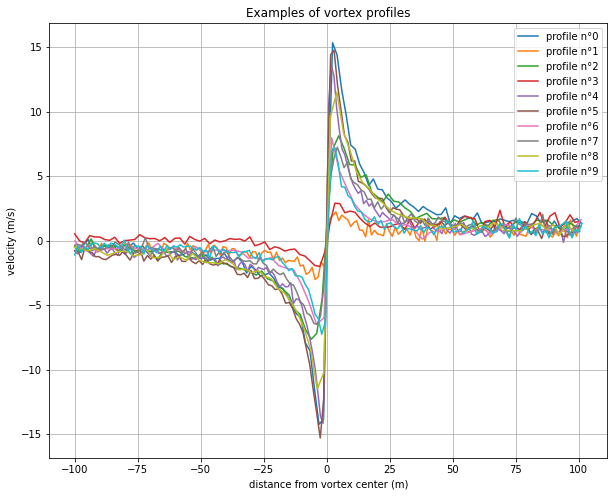

In [46]:
if vortex_generation_on:
    
    #The first 10 profiles are plotted for checking
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for n in range(n_vortices):
        profiles_df = pd.DataFrame({'Radial distances': profiles[0][n],
                                    'Tangential velocities': profiles[1][n]})
        profiles_df.to_csv(profile_filename + str(n) + '.csv', index=False)
        
        if n < 10:
            label='profile n°' + str(n)
            plt.plot(profiles[0][n], profiles[1][n], label=label)
        
    ax.set(xlabel='distance from vortex center (m)', ylabel='velocity (m/s)', title='Examples of vortex profiles')

    plt.grid(b=True)

    fig.savefig("./images/example_of_lidar_envelopes.png")
    plt.legend()

## Fit of the generated profiles using fitting function

#### Read the file containing vortex initial data

In [47]:
vortices_df = pd.read_csv(vortex_filename)

In [48]:
vortices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Vortex                     1000 non-null   int64  
 1   Circulation                1000 non-null   int64  
 2   Core size                  1000 non-null   float64
 3   5-15m Circulation (model)  1000 non-null   float64
 4   Delta R                    1000 non-null   float64
 5   Delta V                    1000 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 47.0 KB


In [49]:
vortices_df.head()

,Vortex,Circulation,Core size,5-15m Circulation (model),Delta R,Delta V
0,0,467,2.41,434.379493,0.295033,0.369452
1,1,115,3.96,96.249693,0.314386,-0.295177
2,2,464,4.71,365.373259,-0.200067,0.186920
3,3,108,3.54,93.306849,0.339458,0.327423
4,4,317,1.78,304.366462,-0.107215,-0.287737


### Fit of all profiles using a Burnham-Hallock function

In [50]:
fitted_values = []

for n in range(n_vortices):
    
    # Open file containing LiDAR vortex profiles
    filename = profile_filename + str(n) + '.csv'
    profile = pd.read_csv(filename)
    
    # Fit  
    fitted_value, _ = curve_fit(modified_burnham_hallock, 
                                profile.iloc[:,0], 
                                profile.iloc[:,1], 
                                p0 = [100,1,0,0])
    
    # Add 5-15m circulation from LiDAR
    fitted_value = np.append(fitted_value, 
                             circulation_discrete_integral(profile.iloc[:,0], profile.iloc[:,1], a=5, b=15))
    
    # Add 5-15m circulation from Fit
    fitted_value = np.append(fitted_value,
                             circulation_full_integral(modified_burnham_hallock, 
                                                       5, 15, 
                                                       fitted_value[0],
                                                       fitted_value[1], 
                                                       0,
                                                       0))
    
    # Append fitted values
    fitted_values.append(fitted_value)

In [51]:
fitted_profiles_df = pd.DataFrame({'LiDAR 5-15m Circulation': [fv[4] for fv in fitted_values],
                                   'Circulation from fit': [fv[0] for fv in fitted_values], 
                                   'Core size from fit': [abs(fv[1]) for fv in fitted_values],
                                   '5-15m Circulation from fit': [fv[5] for fv in fitted_values],
                                   'Delta r from fit': [fv[2] for fv in fitted_values],
                                   'Delta V from fit': [fv[3] for fv in fitted_values]})

In [52]:
fitted_profiles_df.head()

,LiDAR 5-15m Circulation,Circulation from fit,Core size from fit,5-15m Circulation from fit,Delta r from fit,Delta V from fit
0,441.113359,468.999216,2.422107,435.940865,0.276276,0.402099
1,98.253056,159.314368,5.343136,118.764296,0.114751,-0.032629
2,371.048725,469.605251,4.777582,367.677782,-0.290365,0.199804
3,93.935140,142.758316,4.733796,112.188180,0.482102,0.653844
4,309.769406,325.028291,1.814949,311.590823,-0.088075,-0.175234


### Merge both tables

In [53]:
all_vortex_data = pd.merge(vortices_df, fitted_profiles_df, left_index=True, right_index=True)

In [54]:
all_vortex_data.head()

,Vortex,Circulation,Core size,5-15m Circulation (model),Delta R,Delta V,LiDAR 5-15m Circulation,Circulation from fit,Core size from fit,5-15m Circulation from fit,Delta r from fit,Delta V from fit
0,0,467,2.41,434.379493,0.295033,0.369452,441.113359,468.999216,2.422107,435.940865,0.276276,0.402099
1,1,115,3.96,96.249693,0.314386,-0.295177,98.253056,159.314368,5.343136,118.764296,0.114751,-0.032629
2,2,464,4.71,365.373259,-0.200067,0.186920,371.048725,469.605251,4.777582,367.677782,-0.290365,0.199804
3,3,108,3.54,93.306849,0.339458,0.327423,93.935140,142.758316,4.733796,112.188180,0.482102,0.653844
4,4,317,1.78,304.366462,-0.107215,-0.287737,309.769406,325.028291,1.814949,311.590823,-0.088075,-0.175234


### Comparison of fitted values with original values

#### Visual check of the fitting using the function scatter matrix
- Circulation

Very good correlation between original circulation and circulation obtained from fit. Small circulations may be overestimated by the fitting algorithm.

array([[<AxesSubplot:xlabel='Circulation', ylabel='Circulation'>,
        <AxesSubplot:xlabel='Circulation from fit', ylabel='Circulation'>],
       [<AxesSubplot:xlabel='Circulation', ylabel='Circulation from fit'>,
        <AxesSubplot:xlabel='Circulation from fit', ylabel='Circulation from fit'>]],
      dtype=object)

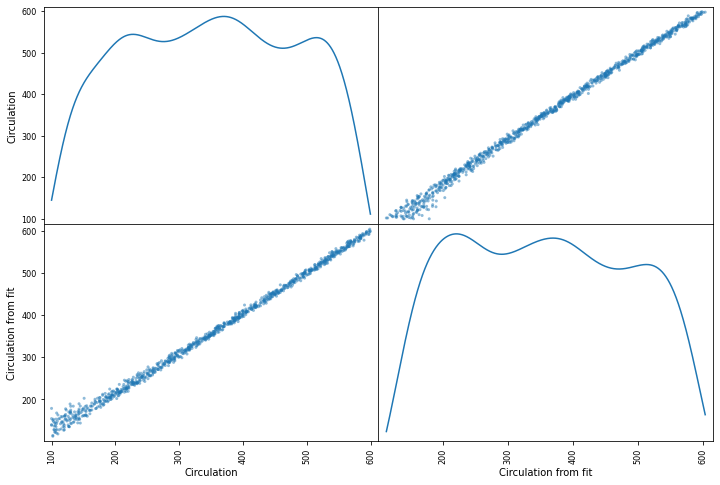

In [55]:
circulations = ['Circulation', 'Circulation from fit']
pd.plotting.scatter_matrix(all_vortex_data[circulations], figsize=(12, 8), grid=True, diagonal='kde')

- 5-15m Circulations

Very good correlations between 5-15m circulations

array([[<AxesSubplot:xlabel='5-15m Circulation (model)', ylabel='5-15m Circulation (model)'>,
        <AxesSubplot:xlabel='LiDAR 5-15m Circulation', ylabel='5-15m Circulation (model)'>,
        <AxesSubplot:xlabel='5-15m Circulation from fit', ylabel='5-15m Circulation (model)'>],
       [<AxesSubplot:xlabel='5-15m Circulation (model)', ylabel='LiDAR 5-15m Circulation'>,
        <AxesSubplot:xlabel='LiDAR 5-15m Circulation', ylabel='LiDAR 5-15m Circulation'>,
        <AxesSubplot:xlabel='5-15m Circulation from fit', ylabel='LiDAR 5-15m Circulation'>],
       [<AxesSubplot:xlabel='5-15m Circulation (model)', ylabel='5-15m Circulation from fit'>,
        <AxesSubplot:xlabel='LiDAR 5-15m Circulation', ylabel='5-15m Circulation from fit'>,
        <AxesSubplot:xlabel='5-15m Circulation from fit', ylabel='5-15m Circulation from fit'>]],
      dtype=object)

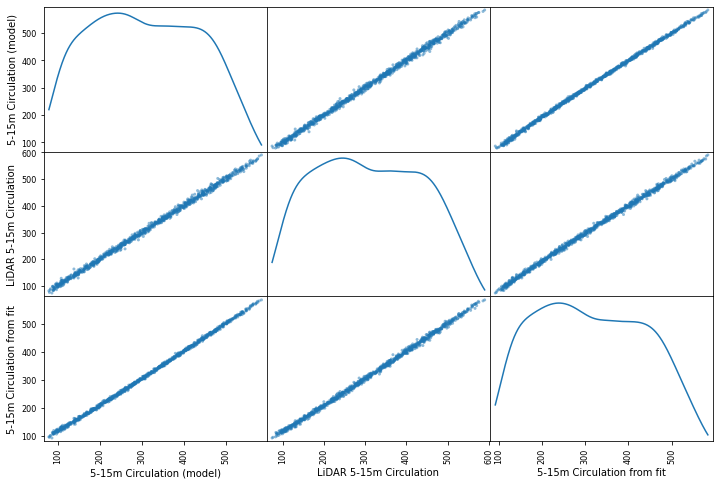

In [56]:
circulations5to15 = ['5-15m Circulation (model)', 'LiDAR 5-15m Circulation', '5-15m Circulation from fit']
pd.plotting.scatter_matrix(all_vortex_data[circulations5to15 ], figsize=(12, 8), grid=True, diagonal='kde')

- Core Size

Relatively good correlation between original core size and core size obtained from fit. Big core radii may be overestimated by the fitting algorithm.

array([[<AxesSubplot:xlabel='Core size', ylabel='Core size'>,
        <AxesSubplot:xlabel='Core size from fit', ylabel='Core size'>],
       [<AxesSubplot:xlabel='Core size', ylabel='Core size from fit'>,
        <AxesSubplot:xlabel='Core size from fit', ylabel='Core size from fit'>]],
      dtype=object)

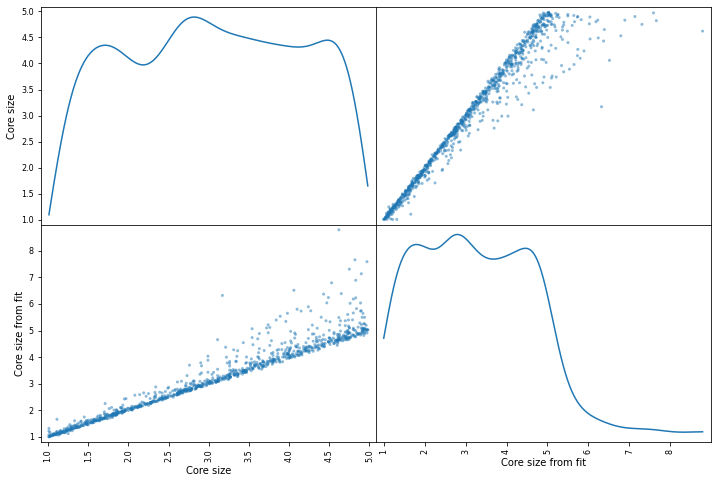

In [57]:
sizes = ['Core size', 'Core size from fit']
pd.plotting.scatter_matrix(all_vortex_data[sizes], figsize=(12, 8), grid=True, diagonal='kde')

#### Errors
In the table, absolute and relative errors on circulations and core sizes are added